## ----- SYSTEMS -----

In [2]:
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tf

import wandb

from functools import partial

from timm.models.vision_transformer import PatchEmbed, Block

from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from tqdm import tqdm

IMAGE_SIZE = 224
BATCH_SIZE = 8
T = 3

c:\Users\detac\miniconda3\envs\pytorch_2_1_0_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set random seed for reproducibility
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(device) if torch.cuda.is_available() else "CPU"
print(device_name)

NVIDIA GeForce RTX 4060 Laptop GPU


## ----- DATASET -----

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None, time_window=T):
        """
        Args:
            root (str): Path to the dataset directory.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root = root
        self.time_window = time_window
        self.file_names = sorted(os.listdir(self.root))
        self.image_names = [f for f in self.file_names if f[0] == "a" and f.endswith(".jpg")] # "axxxx.jpg"
        self.mask_names = ["m" + f[1:-4] + ".png" for f in self.image_names] # "mxxxx.png"
        
        # creat T consecutive image & mask names list
        self.consecutive_image_names = [self.image_names[i:i+self.time_window] for i in range(0, len(self.image_names) - self.time_window + 1)]
        self.consecutive_mask_names = [self.mask_names[i:i+self.time_window] for i in range(0, len(self.mask_names) - self.time_window + 1)]
        
        self.transform = transform

    def __len__(self):
        return len(self.consecutive_image_names)
    
    def __getitem__(self, idx):
        consecutive_image_name = self.consecutive_image_names[idx]
        consecutive_image = [cv2.imread(os.path.join(self.root, image_name), cv2.IMREAD_GRAYSCALE) for image_name in consecutive_image_name]

        consecutive_mask_name = self.consecutive_mask_names[idx]
        consecutive_mask = [cv2.imread(os.path.join(self.root, mask_name), cv2.IMREAD_GRAYSCALE) for mask_name in consecutive_mask_name]
        
        # To tensor and unsqueeze
        for i in range(self.time_window):
            consecutive_image[i] = torch.tensor(consecutive_image[i], dtype=torch.float32)
            consecutive_mask[i] = torch.tensor(consecutive_mask[i], dtype=torch.float32)
        
        # Stack
        images = torch.stack(consecutive_image, dim=0) # [T, H, W]
        masks = torch.stack(consecutive_mask, dim=0) # [T, H, W]
        
        # Unsqueeze
        images = images.unsqueeze(1) # [T, 1, H, W]
        masks = masks.unsqueeze(1) # [T, 1, H, W]
        
        # # Apply transform
        if self.transform:
            images, masks = self.transform(images, masks)
            
        # Sqeeze
        images = images.squeeze(1)
        masks = masks.squeeze(1)
        
        return images, masks

In [5]:
class Augmentation(nn.Module):
    def __init__(self, color_jitter=True, resized_crop=True, horizontal_flip=True):
        self.color_jitter = color_jitter
        self.resized_crop = resized_crop
        self.horizontal_flip = horizontal_flip
    
    def __call__(self, images, masks):
        """ Normalization """
        images = images / 255.0
        masks = masks / 255.0
        
        """ Random Color Jitter"""
        if self.color_jitter and random.random() < 0.5:
            color_transform = tf.Compose([
                tf.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.3),
            ])
            images = color_transform(images)
        
        """ Random Resized Crop """
        if self.resized_crop and random.random() < 0.5:
            # Get parameters for RandomResizedCrop
            top, left, height, width = tf.RandomResizedCrop.get_params(images, scale=(0.7, 1.0), ratio=(0.8, 1.2))
            
            # Apply RandomResizedCrop
            images = tf.functional.resized_crop(
                images,
                top, left, height, width,
                (IMAGE_SIZE, IMAGE_SIZE),
                interpolation=tf.InterpolationMode.BILINEAR,
                antialias=True
            )
            masks = tf.functional.resized_crop(
                masks,
                top, left, height, width,
                (IMAGE_SIZE, IMAGE_SIZE),
                interpolation=tf.InterpolationMode.NEAREST
            )
        
        """ Random Horizontal Flip """
        if self.horizontal_flip and random.random() < 0.5:
            images = tf.functional.hflip(images)
            masks = tf.functional.hflip(masks)

        """ Resize """
        images = tf.functional.resize(images, (IMAGE_SIZE, IMAGE_SIZE), interpolation=tf.InterpolationMode.BILINEAR, antialias=True)
        masks = tf.functional.resize(masks, (IMAGE_SIZE, IMAGE_SIZE), interpolation=tf.InterpolationMode.NEAREST)
        
        return images, masks

In [18]:
train_transform = Augmentation()
valid_transform = Augmentation(color_jitter=False, resized_crop=False, horizontal_flip=True)
vis_valid_transform = Augmentation(color_jitter=False, resized_crop=False, horizontal_flip=False)

""" easy datasets """
# 20231017_08
easy_2220 = CustomDataset("./data/Sonosite_20231017_0833_2220frames_abc", transform=train_transform)
easy_2220_eval = CustomDataset("./data/Sonosite_20231017_0833_2220frames_abc", transform=valid_transform)  # training set for evaluation
# easy_1941 = CustomDataset("./data/Sonosite_20231017_0836_1941frames_abc") 

# 20231107_14
easy_2097 = CustomDataset("./data/Sonosite_20231107_1456_2097frames_abc", transform=valid_transform)  # validation set
easy_2097_vis = CustomDataset("./data/Sonosite_20231107_1456_2097frames_abc", transform=vis_valid_transform)  # validation set for visualization

# 20231128_12
easy_1429 = CustomDataset("./data/Sonosite_20231128_1220_1429frames_abc", transform=train_transform)
easy_1429_eval = CustomDataset("./data/Sonosite_20231128_1220_1429frames_abc", transform=valid_transform)  # training set for evaluation
easy_1063 = CustomDataset("./data/Sonosite_20231128_1259_1063frames_abc", transform=train_transform)
easy_1063_eval = CustomDataset("./data/Sonosite_20231128_1259_1063frames_abc", transform=valid_transform)  # training set for evaluation

# 20231128_14
easy_270 = CustomDataset("./data/Sonosite_20231128_1423-1_270frames_abc", transform=train_transform)
easy_270_eval = CustomDataset("./data/Sonosite_20231128_1423-1_270frames_abc", transform=valid_transform)  # training set for evaluation
easy_1295 = CustomDataset("./data/Sonosite_20231128_1423-2_1295frames_abc", transform=train_transform)
easy_1295_eval = CustomDataset("./data/Sonosite_20231128_1423-2_1295frames_abc", transform=valid_transform)  # training set for evaluation
easy_1058 = CustomDataset("./data/Sonosite_20231128_1429_1058frams_abc", transform=train_transform)
easy_1058_eval = CustomDataset("./data/Sonosite_20231128_1429_1058frams_abc", transform=valid_transform)  # training set for evaluation

# 20231201_09
easy_679 = CustomDataset("./data/Sonosite_20231201_0910_679frams_abc", transform=valid_transform)  # validation set
easy_679_vis = CustomDataset("./data/Sonosite_20231201_0910_679frams_abc", transform=vis_valid_transform)  # validation set for visualization
easy_1530 = CustomDataset("./data/Sonosite_20231201_0913_1530frames_abc", transform=valid_transform)  # validation set
easy_1530_vis = CustomDataset("./data/Sonosite_20231201_0913_1530frames_abc", transform=vis_valid_transform)  # validation set for visualization
easy_1148 = CustomDataset("./data/Sonosite_20231201_0921_1148frames_abc", transform=valid_transform)  # validation set
easy_1148_vis = CustomDataset("./data/Sonosite_20231201_0921_1148frames_abc", transform=vis_valid_transform)  # validation set for visualization


""" easy & medium datasets """
# 20231110_09
easy_284 = CustomDataset("./data/Sonosite_20231110_0903-2_284frames_abc", transform=train_transform)
easy_284_eval = CustomDataset("./data/Sonosite_20231110_0903-2_284frames_abc", transform=valid_transform)  # training set for evaluation
medium_1903 = CustomDataset("./data/Sonosite_20231110_0910_1903frames_abc", transform=train_transform)
medium_1903_eval = CustomDataset("./data/Sonosite_20231110_0910_1903frames_abc", transform=valid_transform)  # training set for evaluation


""" medium datasets """
# 20231003_09
medium_1120 = CustomDataset("./data/Sonosite_20231003_0945_1120frames_abc", transform=valid_transform)  # test set

# 20231003_10
medium_755 = CustomDataset("./data/Sonosite_20231003_1028_755frames_abc", transform=valid_transform)  # test set

# 20231024_09
medium_990 = CustomDataset("./data/Sonosite_20231024_0909_990frames_abc", transform=valid_transform)  # test set

# 20231024_12
medium_1704 = CustomDataset("./data/Sonosite_20231024_1228_1704frames_abc", transform=valid_transform)  # test set


""" hard datasets """
# 20230613_10
hard_574 = CustomDataset("./data/Sonosite_20230613_1033_574frames_abc", transform=valid_transform)  # test set

# 20230613_13
hard_549 = CustomDataset("./data/Sonosite_20230613_1329_549frames_abc", transform=valid_transform)  # test set

# 20231024_15
hard_412 = CustomDataset("./data/Sonosite_20231024_1520_412frames_abc", transform=valid_transform)  # test set

# 20231031_13
hard_950 = CustomDataset("./data/Sonosite_20231031_1322_950frames_abc", transform=valid_transform)  # test set
hard_1320 = CustomDataset("./data/Sonosite_20231031_1345_1320frames_abc", transform=valid_transform)  # test set


""" training dataset """
train_dataset = ConcatDataset(
    [
        easy_2220, 
        easy_1429, 
        easy_1063,
        easy_270,
        easy_1295,
        easy_1058,
        easy_284,
        medium_1903,
    ]
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

""" training dataset for evaluation """
train_eval_dataset = ConcatDataset(
    [
        easy_2220_eval,
        easy_1429_eval,
        easy_1063_eval,
        easy_270_eval,
        easy_1295_eval,
        easy_1058_eval,
        easy_284_eval,
        medium_1903_eval,
    ]
)
train_eval_loader = DataLoader(train_eval_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

""" validation dataset """
valid_dataset = ConcatDataset(
    [
        easy_2097,
        easy_679,
        easy_1530,
        easy_1148,
    ]
)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

""" validation dataset for visualization """
vis_valid_dataset = ConcatDataset(
    [
        easy_2097_vis,
        easy_679_vis,
        easy_1530_vis,
        easy_1148_vis,
    ]
)
vis_valid_loader = DataLoader(vis_valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


""" medium test dataset """
medium_test_dataset = ConcatDataset(
    [
        medium_1120,
        medium_755,
        medium_990,
        medium_1704,
    ]
)
medium_test_loader = DataLoader(medium_test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

""" hard test dataset """
hard_test_dataset = ConcatDataset(
    [
        hard_574,
        hard_549,
        hard_412,
        hard_950,
        hard_1320,
    ]
)
hard_test_loader = DataLoader(hard_test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)


print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of training evaluation samples: {len(train_eval_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")
print(f"Number of validation visualization samples: {len(vis_valid_dataset)}")
print(f"Number of medium test samples: {len(medium_test_dataset)}")
print(f"Number of hard test samples: {len(hard_test_dataset)}")

Number of training samples: 4429
Number of training evaluation samples: 4429
Number of validation samples: 2545
Number of validation visualization samples: 2545
Number of medium test samples: 2135
Number of hard test samples: 1853


Batch 0, Consecutive Images Shape: torch.Size([8, 3, 224, 224]), Consecutive Masks Shape: torch.Size([8, 3, 224, 224])


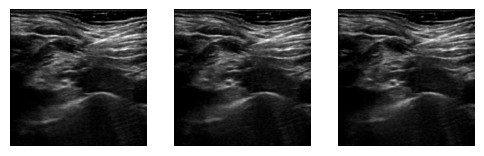

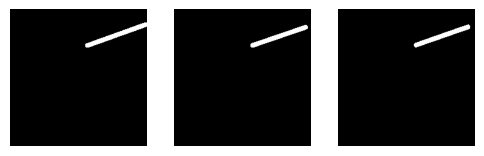

----------------------------------------------------------------


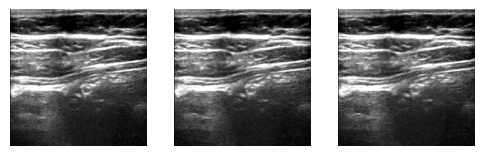

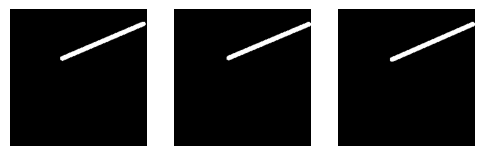

----------------------------------------------------------------


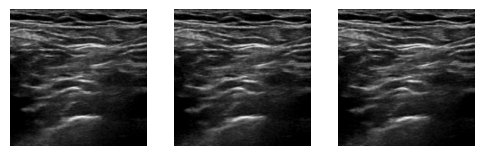

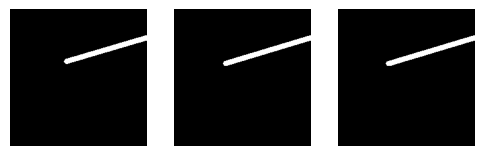

----------------------------------------------------------------


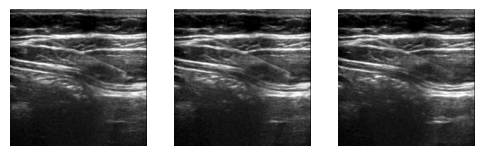

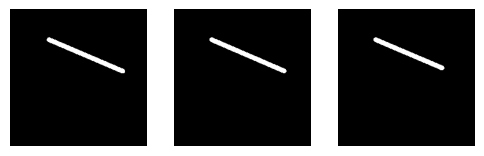

----------------------------------------------------------------
Batch 1, Consecutive Images Shape: torch.Size([8, 3, 224, 224]), Consecutive Masks Shape: torch.Size([8, 3, 224, 224])


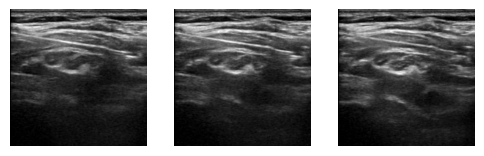

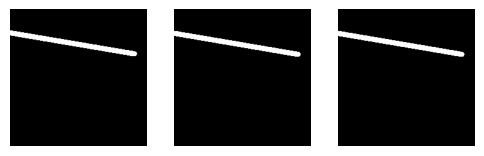

----------------------------------------------------------------


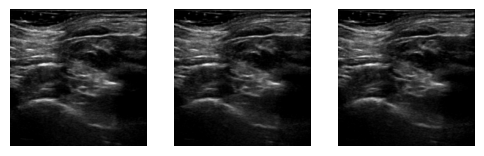

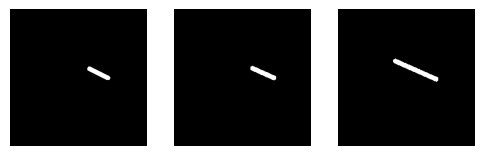

----------------------------------------------------------------


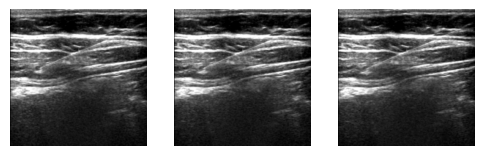

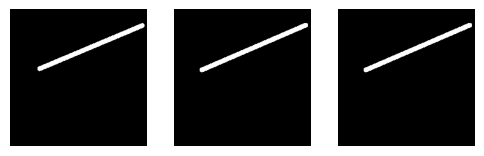

----------------------------------------------------------------


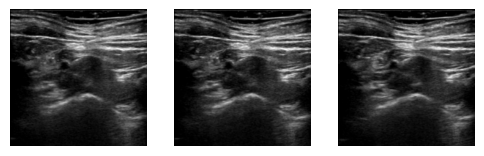

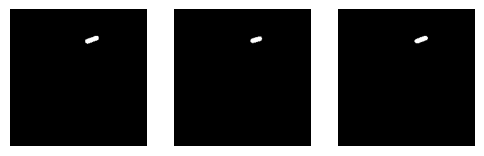

----------------------------------------------------------------


In [7]:
# Visualize some batches of image pairs (show only 4 consecutive images at most)
def show_image_pairs(cons_images, cons_masks, cons_preds=None, preds=None, figsize=(6, 2)):
    # Show 4 consecutive images in a batch at most
    for sample in range(cons_images.shape[0]):
        cons_img = cons_images[sample]
        cons_mask = cons_masks[sample]
        if cons_preds is not None:
            cons_pred = cons_preds[sample]  # [T, H, W]
        if preds is not None:
            pred = preds[sample][0].numpy()  # [H, W]
        
        # Show consecutive images
        plt.figure(figsize=figsize)
        for t, img in enumerate(cons_img):
            img = img.numpy()
            img[img <= 0] = 0
            img[img >= 1] = 1
            img = (img * 255).astype(np.uint8)
            plt.subplot(1, len(cons_img), t+1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
        plt.show()
        
        # Show consecutive masks
        plt.figure(figsize=figsize)
        for t, mask in enumerate(cons_mask):
            mask = mask.numpy()
            mask = (mask * 255).astype(np.uint8)
            plt.subplot(1, len(cons_mask), t+1)
            plt.imshow(mask, cmap="gray")
            plt.axis("off")
        plt.show()
        
        # Show consecutive predictions
        if cons_preds is not None:
            plt.figure(figsize=figsize)
            for t, pred in enumerate(cons_pred):
                pred = pred.detach().cpu().numpy()
                pred[pred <= 0.5] = 0
                pred[pred >= 0.5] = 1
                pred = (pred * 255).astype(np.uint8)
                plt.subplot(1, len(cons_pred), t+1)
                plt.imshow(pred, cmap="gray")
                plt.axis("off")
            plt.show()
        
        # Show middle frame predictions
        if preds is not None:
            plt.figure(figsize=figsize)
            for t in range(3):
                if not t == 1:
                    pred_mask = np.zeros_like(pred)
                else:
                    pred_mask = pred
                pred_mask[pred_mask <= 0.5] = 0
                pred_mask[pred_mask >= 0.5] = 1
                pred_mask = (pred_mask * 255).astype(np.uint8)
                plt.subplot(1, len(cons_img), t+1)
                plt.imshow(pred_mask, cmap="gray")
                plt.axis("off")
            plt.show()
        
        print("----------------------------------------------------------------")
        # break after showing 4 samples
        if sample == 3:
            break

# Show 2 batches of images
for batch_id, (images, masks) in enumerate(train_loader):
    print(f"Batch {batch_id}, Consecutive Images Shape: {images.shape}, Consecutive Masks Shape: {masks.shape}")
    show_image_pairs(images, masks)
    if batch_id == 1:
        break

## ----- MODEL -----

In [8]:
""" Positional Encoding for ViT """

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


""" Blocks for skip connections & upsampling """

# Single convolutional block with GroupNorm and GELU activation
# Yellow block in the UNETR paper architecture diagram with some modification (BatchNorm -> GropNorm, ReLU -> GELU)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups=8, dropout_rate=0.1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm = nn.GroupNorm(groups, out_channels)
        self.act = nn.GELU()
        self.dropout = nn.Dropout2d(dropout_rate)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        if self.dropout.p > 0.:
            x = self.dropout(x)
        return x

# 2 BasicBlock with residual connection
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        """ convolutional layers """
        self.block1 = BasicBlock(in_channels, out_channels)
        self.block2 = BasicBlock(out_channels, out_channels)
        
        """ identity mapping """
        self.res = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = out + self.res(x)
        return out

# Skip connection block (transpose convolution followed by a BasicBlock)
class SkipBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.transp = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.block = BasicBlock(out_channels, out_channels)
    
    def forward(self, x):
        x = self.transp(x)
        x = self.block(x)
        return x

# Upsampling block
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=4, stride=2, padding=1)
        self.res_block = ResidualBlock(in_channels, out_channels)
    
    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.res_block(x)
        return x

        
""" UNETR model """

class UNTER(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=T, out_chans=T,
                 embed_dim=768, depth=12, num_heads=12,
                 mlp_ratio=4., norm_layer=nn.LayerNorm,
                 skip_chans=[64, 128, 256]):
        super().__init__() # Default ViT encoder initialization parameters are for ViT-B/16
        if depth % 4 != 0:
            raise ValueError("Depth must be divisible by 4 for skip connections in UNETR.")
        # --------------------------------------------------------------------------
        # ViT encoder
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding in later initialization

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------
        
        # --------------------------------------------------------------------------
        # skip connection blocks
        self.skip_encoder_ids = [depth // 4 - 1, depth // 4 * 2 - 1, depth // 4 * 3 - 1] # [2, 5, 8] for depth=12 & [1, 3, 5] for depth=8
        self.skip1 = nn.Sequential(
            SkipBlock(embed_dim, skip_chans[0]),
            SkipBlock(skip_chans[0], skip_chans[0]),
            SkipBlock(skip_chans[0], skip_chans[0]),
        )
        self.skip2 = nn.Sequential(
            SkipBlock(embed_dim, skip_chans[1]),
            SkipBlock(skip_chans[1], skip_chans[1]),
        )
        self.skip3 = nn.Sequential(
            SkipBlock(embed_dim, skip_chans[2]),
        )
        # --------------------------------------------------------------------------
        
        # --------------------------------------------------------------------------
        # bottleneck block
        self.bottem_up = nn.ConvTranspose2d(embed_dim, skip_chans[2], kernel_size=4, stride=2, padding=1)
        self.bottem_res_block = ResidualBlock(skip_chans[2]*2, skip_chans[2])
        # --------------------------------------------------------------------------
        
        # --------------------------------------------------------------------------
        # upsampling blocks
        self.up3 = UpsampleBlock(skip_chans[2], skip_chans[1])
        self.up2 = UpsampleBlock(skip_chans[1], skip_chans[0])
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(skip_chans[0], skip_chans[0]//2, kernel_size=4, stride=2, padding=1),
            ResidualBlock(skip_chans[0]//2, skip_chans[0]//2),
        )
        # --------------------------------------------------------------------------
        
        # --------------------------------------------------------------------------
        # output
        self.out_conv = nn.Conv2d(skip_chans[0]//2, out_chans, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()
        # --------------------------------------------------------------------------
        
        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def vit_encoder(self, x):
        # embed patches
        x = self.patch_embed(x) # [N, L, D]

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :] # [N, L, D]

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :] # [1, 1, D]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1) # [N, 1, D]
        x = torch.cat((cls_tokens, x), dim=1) # [N, L+1, D]

        # store latent features from ViT block
        latents_out = []
        
        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
            latents_out.append(x)
        x = self.norm(x)
        
        return x, latents_out
    
    def latent_reshape(self, latents):
        """
        input:
        latents: (N, L+1, D)
        return:
        latents: (N, D, H//p, W//p)
        """
        # remove cls token
        latents = latents[:, 1:, :]
        
        h = w = int(latents.shape[1]**.5)
        latents = latents.reshape(shape=(latents.shape[0], h, w, latents.shape[2])) # [N, H//p, W//p, D]
        
        # reshape to (N, D, H//p, W//p)
        latents = latents.permute(0, 3, 1, 2)
        
        return latents
        
    def forward(self, imgs):
        # ViT encoder
        x, latents_out = self.vit_encoder(imgs) # x & all latents with dim [N, L+1, D]
        
        # default skip_chans: [64, 128, 256]
        # skip connection from latents 1
        latents1 = self.latent_reshape(latents_out[self.skip_encoder_ids[0]]) # [N, D, H//p, W//p]
        s1 = self.skip1(latents1) # [N, skip_chans[0], H//2, W//2]
        
        # skip connection from latents 2
        latents2 = self.latent_reshape(latents_out[self.skip_encoder_ids[1]]) # [N, D, H//p, W//p]
        s2 = self.skip2(latents2) # [N, skip_chans[1], H//4, W//4]
        
        # skip connection from latents 3
        latents3 = self.latent_reshape(latents_out[self.skip_encoder_ids[2]]) # [N, D, H//p, W//p]
        s3 = self.skip3(latents3) # [N, skip_chans[2], H//8, W//8]
        
        # bottleneck block
        x = self.latent_reshape(x) # [N, D, H//p, W//p]
        x = self.bottem_up(x) # [N, skip_chans[2], H//8, W//8]
        x = self.bottem_res_block(torch.cat([x, s3], dim=1)) # [N, skip_chans[2], H//8, W//8]
        
        # upsampling blocks
        x = self.up3(x, s2) # [N, skip_chans[1], H//4, W//4]
        x = self.up2(x, s1) # [N, skip_chans[0], H//2, W//2]
        x = self.up1(x) # [N, skip_chans[0]//2, H, W]
        
        # output
        x = self.out_conv(x) # [N, out_chans, H, W]
        x = self.sigmoid(x)
        
        return x

## ----- LOSS FUNCTION -----

In [10]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        # flatten prediction and target tensors
        preds = preds.reshape(-1) # [N, T, H, W] -> [N*T*H*W] or [N, 1, H, W] -> [N*H*W]
        targets = targets.reshape(-1) # [N, T, H, W] -> [N*T*H*W] or [N, 1, H, W] -> [N*H*W]
        
        alpha_factor = torch.where(targets == 1, self.alpha, 1. - self.alpha)

        # compute binary cross-entropy
        bce_loss = F.binary_cross_entropy(preds, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = alpha_factor* (1-pt)**self.gamma * bce_loss
        
        return focal_loss.mean()

In [11]:
# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, preds, targets, smooth=1e-6):
        # flatten prediction and target tensors
        preds = preds.reshape(-1) # [N, T, H, W] -> [N*T*H*W] or [N, 1, H, W] -> [N*H*W]
        targets = targets.reshape(-1) # [N, T, H, W] -> [N*T*H*W] or [N, 1, H, W] -> [N*H*W]
        
        intersection = (preds * targets).sum()
        dice_coeff = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
        
        return 1 - dice_coeff

In [ ]:
# # clDice Loss
# class soft_cldice(nn.Module):
#     def __init__(self, iter_=3, smooth = 1., exclude_background=False):
#         super(soft_cldice, self).__init__()
#         self.iter = iter_
#         self.smooth = smooth
#         self.soft_skeletonize = SoftSkeletonize(num_iter=10)
#         self.exclude_background = exclude_background

#     def forward(self, y_true, y_pred):
#         if self.exclude_background:
#             y_true = y_true[:, 1:, :, :]
#             y_pred = y_pred[:, 1:, :, :]
#         skel_pred = self.soft_skeletonize(y_pred)
#         skel_true = self.soft_skeletonize(y_true)
#         tprec = (torch.sum(torch.multiply(skel_pred, y_true))+self.smooth)/(torch.sum(skel_pred)+self.smooth)    
#         tsens = (torch.sum(torch.multiply(skel_true, y_pred))+self.smooth)/(torch.sum(skel_true)+self.smooth)    
#         cl_dice = 1.- 2.0*(tprec*tsens)/(tprec+tsens)
#         return cl_dice


# def soft_dice(y_true, y_pred):
#     """[function to compute dice loss]

#     Args:
#         y_true ([float32]): [ground truth image]
#         y_pred ([float32]): [predicted image]

#     Returns:
#         [float32]: [loss value]
#     """
#     smooth = 1
#     intersection = torch.sum((y_true * y_pred))
#     coeff = (2. *  intersection + smooth) / (torch.sum(y_true) + torch.sum(y_pred) + smooth)
#     return (1. - coeff)


# class soft_dice_cldice(nn.Module):
#     def __init__(self, iter_=3, alpha=0.5, smooth = 1., exclude_background=False):
#         super(soft_dice_cldice, self).__init__()
#         self.iter = iter_
#         self.smooth = smooth
#         self.alpha = alpha
#         self.soft_skeletonize = SoftSkeletonize(num_iter=10)
#         self.exclude_background = exclude_background

#     def forward(self, y_true, y_pred):
#         if self.exclude_background:
#             y_true = y_true[:, 1:, :, :]
#             y_pred = y_pred[:, 1:, :, :]
#         dice = soft_dice(y_true, y_pred)
#         skel_pred = self.soft_skeletonize(y_pred)
#         skel_true = self.soft_skeletonize(y_true)
#         tprec = (torch.sum(torch.multiply(skel_pred, y_true))+self.smooth)/(torch.sum(skel_pred)+self.smooth)    
#         tsens = (torch.sum(torch.multiply(skel_true, y_pred))+self.smooth)/(torch.sum(skel_true)+self.smooth)    
#         cl_dice = 1.- 2.0*(tprec*tsens)/(tprec+tsens)
#         return (1.0-self.alpha)*dice+self.alpha*cl_dice

# class SoftSkeletonize(torch.nn.Module):
#     def __init__(self, num_iter=40):
#         super(SoftSkeletonize, self).__init__()
#         self.num_iter = num_iter

#     def soft_erode(self, img):
#         if len(img.shape)==4:
#             p1 = -F.max_pool2d(-img, (3,1), (1,1), (1,0))
#             p2 = -F.max_pool2d(-img, (1,3), (1,1), (0,1))
#             return torch.min(p1,p2)
#         elif len(img.shape)==5:
#             p1 = -F.max_pool3d(-img,(3,1,1),(1,1,1),(1,0,0))
#             p2 = -F.max_pool3d(-img,(1,3,1),(1,1,1),(0,1,0))
#             p3 = -F.max_pool3d(-img,(1,1,3),(1,1,1),(0,0,1))
#             return torch.min(torch.min(p1, p2), p3)

#     def soft_dilate(self, img):
#         if len(img.shape)==4:
#             return F.max_pool2d(img, (3,3), (1,1), (1,1))
#         elif len(img.shape)==5:
#             return F.max_pool3d(img,(3,3,3),(1,1,1),(1,1,1))

#     def soft_open(self, img):
#         return self.soft_dilate(self.soft_erode(img))

#     def soft_skel(self, img):
#         img1 = self.soft_open(img)
#         skel = F.relu(img-img1)

#         for j in range(self.num_iter):
#             img = self.soft_erode(img)
#             img1 = self.soft_open(img)
#             delta = F.relu(img-img1)
#             skel = skel + F.relu(delta - skel * delta)

#         return skel

#     def forward(self, img):
#         return self.soft_skel(img)

In [ ]:
# # IoU Loss
# class IoULoss(nn.Module):
#     def __init__(self):
#         super(IoULoss, self).__init__()

#     def forward(self, preds, targets, smooth=1):
#         # flatten prediction and target tensors
#         preds = preds.view(-1) # [N, 1, H, W] -> [N*H*W]
#         targets = targets.view(-1) # [N, 1, H, W] -> [N*H*W]

#         # intersection is equivalent to True Positive count
#         # union is the mutually inclusive area of all labels & predictions
#         intersection = (preds * targets).sum()
#         total = (preds + targets).sum()
#         union = total - intersection

#         IoU = (intersection + smooth)/(union + smooth)

#         return 1 - IoU

## ----- EVALUATION FUNCTION -----

In [12]:
# Dice Score Function
def dice_score(preds, masks):
    smooth = 1  # avoid division by zero
    preds = (preds > 0.5)
    masks = (masks > 0)
    
    intersection = (preds & masks).float().sum()
    dice = (2 * intersection + smooth) / (preds.float().sum() + masks.float().sum() + smooth)
    
    return dice


# IoU Score Function
def iou_score(preds, masks):
    smooth = 1  # avoid division by zero
    preds = (preds > 0.5)
    masks = (masks > 0)
    
    intersection = (preds & masks).float().sum()
    union = (preds | masks).float().sum()
    iou = (intersection + smooth) / (union + smooth)
    
    return iou


# Recall Score Function
def recall_score(preds, masks):
    smooth = 1  # avoid division by zero
    preds = (preds > 0.5)
    masks = (masks > 0)
    
    intersection = (preds & masks).float().sum()
    recall = (intersection + smooth) / (masks.float().sum() + smooth)
    
    return recall


# Precision Score Function
def precision_score(preds, masks):
    smooth = 1  # avoid division by zero
    preds = (preds > 0.5)
    masks = (masks > 0)
    
    intersection = (preds & masks).float().sum()
    precision = (intersection + smooth) / (preds.float().sum() + smooth)
    
    return precision


# Evaluation Function
def evaluate(model, loader, focal_loss, dice_loss, device, target_t="all"):
    print("Evaluating the model...")
    model.eval()
    model.to(device)
    total_loss = 0.0
    total_focal_loss = 0.0
    total_dice_loss = 0.0
    total_dice_score = 0.0
    total_iou_score = 0.0
    total_recall_score = 0.0
    total_precision_score = 0.0
    
    with torch.no_grad():
        for step, (images, masks) in enumerate(tqdm(loader)):
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            preds = model(images)  # [N, T, H, W] if target_t == "all" or [N, 1, H, W] if target_t == "mid"
            
            # Select target mask time frame
            if target_t == "mid":
                masks = masks[:, 1, :, :].unsqueeze(1)  # [N, 1, H, W]

            # Calculate loss & IoU score
            fl = focal_loss(preds, masks)
            dl = dice_loss(preds, masks)
            loss = fl + dl
            dscore = dice_score(preds, masks)
            iscore = iou_score(preds, masks)
            rsocre = recall_score(preds, masks)
            pscore = precision_score(preds, masks)
            
            # Accumulate loss & IoU score
            total_loss += loss.item()
            total_focal_loss += fl.item()
            total_dice_loss += dl.item()
            total_dice_score += dscore.item()
            total_iou_score += iscore.item()
            total_recall_score += rsocre.item()
            total_precision_score += pscore.item()
    
    results = (
        total_loss / len(loader), 
        total_focal_loss / len(loader), 
        total_dice_loss / len(loader),
        total_dice_score / len(loader),
        total_iou_score / len(loader),
        total_recall_score / len(loader),
        total_precision_score / len(loader)
    )
    
    return results
            

## ----- TRAINING FUNCTION -----

In [16]:
def train(experiment_id, model, train_loader, valid_loader, optimizer, focal_loss, dice_loss, device, epochs, accumulation_steps=8, scheduler=None, target_t="all"):
    model.train()
    model.to(device)
    
    best_valid_loss = float("inf")
    best_valid_focal_loss = float("inf")
    best_valid_dice_loss = float("inf")
    best_valid_dice_score = 0.0
    best_valid_iou_score = 0.0
    best_valid_recall_score = 0.0
    best_valid_precision_score = 0.0
    early_stop_count = 0
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        running_loss = 0.0
        running_focal_loss = 0.0
        running_dice_loss = 0.0
        running_dice_score = 0.0
        running_iou_score = 0.0
        running_recall_score = 0.0
        running_precision_score = 0.0
        
        for step, (images, masks) in enumerate(tqdm(train_loader)):
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            preds = model(images)  # [N, T, H, W] if target_t == "all" or [N, 1, H, W] if target_t == "mid"
            
            # Select target mask time frame
            if target_t == "mid":
                masks = masks[:, 1, :, :].unsqueeze(1)  # [N, 1, H, W]
            
            # Calculate loss & IoU score
            fl = focal_loss(preds, masks)
            dl = dice_loss(preds, masks)
            loss = fl + dl
            dscore = dice_score(preds, masks)
            iscore = iou_score(preds, masks)
            rscore = recall_score(preds, masks)
            pscore = precision_score(preds, masks)
            
            # running loss & IoU score
            running_loss += loss.item()
            running_focal_loss += fl.item()
            running_dice_loss += dl.item()
            running_dice_score += dscore.item()
            running_iou_score += iscore.item()
            running_recall_score += rscore.item()
            running_precision_score += pscore.item()
            
            # Gradient accumulation normalization
            loss = loss / accumulation_steps
            loss.backward()
            
            # Update weights
            if (step + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        
        if scheduler is not None:
            # Adjust learning rate
            scheduler.step()
        
        # Print running loss & IoU score on training data
        print("--------------------------------------------------")
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Evaluation on Training Data:")
        print(f"Loss: {running_loss/len(train_loader):.6f}")
        print(f"Focal Loss: {running_focal_loss/len(train_loader):.6f}")
        print(f"Dice Loss: {running_dice_loss/len(train_loader):.6f}")
        print(f"Dice Score: {running_dice_score/len(train_loader):.6f}")
        print(f"IoU Score: {running_iou_score/len(train_loader):.6f}")
        print(f"Recall Score: {running_recall_score/len(train_loader):.6f}")
        print(f"Precision Score: {running_precision_score/len(train_loader):.6f}")
        print("--------------------------------------------------")
        
        # Evaluate the model
        valid_loss, valid_focal_loss, valid_dice_loss, valid_dice_score, valid_iou_score, valid_recall_score, valid_precision_score = evaluate(model, valid_loader, focal_loss, dice_loss, device, target_t)
        print("--------------------------------------------------")
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Evaluation on Validation Data:")
        print(f"Loss: {valid_loss:.6f}")
        print(f"Focal Loss: {valid_focal_loss:.6f}")
        print(f"Dice Loss: {valid_dice_loss:.6f}")
        print(f"Dice Score: {valid_dice_score:.6f}")
        print(f"IoU Score: {valid_iou_score:.6f}")
        print(f"Recall Score: {valid_recall_score:.6f}")
        print(f"Precision Score: {valid_precision_score:.6f}")
        print("--------------------------------------------------")
        
        # Update the best validation loss & IoU score
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
        if valid_focal_loss < best_valid_focal_loss:
            best_valid_focal_loss = valid_focal_loss
        if valid_dice_loss < best_valid_dice_loss:
            best_valid_dice_loss = valid_dice_loss
        if valid_dice_score > best_valid_dice_score:
            best_valid_dice_score = valid_dice_score
        if valid_iou_score > best_valid_iou_score:
            best_valid_iou_score = valid_iou_score
        if valid_recall_score > best_valid_recall_score:
            best_valid_recall_score = valid_recall_score
        if valid_precision_score > best_valid_precision_score:
            best_valid_precision_score = valid_precision_score
        
        # Save the best model & visualize the output if the model is improved
        if valid_loss == best_valid_loss:
            early_stop_count = 0
            
            # Save the best model
            torch.save(model.state_dict(), f"./new_video_unetr_checkpoints/video_unetr_best_{experiment_id}.pth")
            print("The best model is saved!")
            
            # Visualize the output on training data (show the first batch)
            print("Visualizing the output on training data...")
            model.eval()
            with torch.no_grad():
                for t_step, (t_images, t_masks) in enumerate(train_loader):
                    # Move to device & forward pass
                    t_images = t_images.to(device)
                    t_preds = model(t_images)
                    
                    # Detach and move to CPU
                    t_images = t_images.detach().cpu()
                    t_preds = t_preds.detach().cpu()
                    
                    if target_t == "mid":
                        show_image_pairs(cons_images=t_images, cons_masks=t_masks, cons_preds=None, preds=t_preds)
                    else:
                        show_image_pairs(cons_images=t_images, cons_masks=t_masks, cons_preds=t_preds, preds=None)
                    break
            
            # Visualize the output on validation data (show the first batch)
            print("Visualizing the output on validation data...")
            model.eval()
            with torch.no_grad():
                for v_step, (v_images, v_masks) in enumerate(valid_loader):
                    # Move to device & forward pass
                    v_images = v_images.to(device)
                    v_preds = model(v_images)
                    
                    # Detach and move to CPU
                    v_images = v_images.detach().cpu()
                    v_preds = v_preds.detach().cpu()
                    
                    if target_t == "mid":
                        show_image_pairs(cons_images=v_images, cons_masks=v_masks, cons_preds=None, preds=v_preds)
                    else:
                        show_image_pairs(cons_images=v_images, cons_masks=v_masks, cons_preds=v_preds, preds=None)
                    break
        else:
            early_stop_count += 1
            if early_stop_count == 5:
                print("Early stopping...")
                break
        
        # Show the best loss & IoU loss & IoU score
        print("--------------------------------------------------")
        print(f"Best Validation Loss: {best_valid_loss:.6f}")
        print(f"Best Validation Focal Loss: {best_valid_focal_loss:.6f}")
        print(f"Best Validation Dice Loss: {best_valid_dice_loss:.6f}")
        print(f"Best Validation Dice Score: {best_valid_dice_score:.6f}")
        print(f"Best Validation IoU Score: {best_valid_iou_score:.6f}")
        print(f"Best Validation Recall Score: {best_valid_recall_score:.6f}")
        print(f"Best Validation Precision Score: {best_valid_precision_score:.6f}")
        print("--------------------------------------------------")
            
        model.train()
        
        # Log to wandb
        wandb.log({
            "Training Loss": running_loss/len(train_loader),
            "Training Focal Loss": running_focal_loss/len(train_loader),
            "Training Dice Loss": running_dice_loss/len(train_loader),
            "Training Dice Score": running_dice_score/len(train_loader),
            "Training IoU Score": running_iou_score/len(train_loader),
            "Training Recall Score": running_recall_score/len(train_loader),
            "Training Precision Score": running_precision_score/len(train_loader),
            "Validation Loss": valid_loss,
            "Validation Focal Loss": valid_focal_loss,
            "Validation Dice Loss": valid_dice_loss,
            "Validation Dice Score": valid_dice_score,
            "Validation IoU Score": valid_iou_score,
            "Validation Recall Score": valid_recall_score,
            "Validation Precision Score": valid_precision_score
        })
    
    print("Finished Training!")

## ----- EXPERIMENTS -----

In [ ]:
""" -------------------------------------------------------------------------------------------------- """
""" Experiment ID """

experiment_id = 1


""" Target Mask Time Frame"""

if experiment_id == 1:
    target_t = "all"
    out_chans = T
elif experiment_id == 2:
    target_t = "mid"
    out_chans = 1

""" -------------------------------------------------------------------------------------------------- """


# Set the name of the experiment for wandb logging
name = f"New-Video-UNETR-{experiment_id}"


# Define the model parameters
patch_size = 16
embed_dim = 768
depth = 12
num_heads = 12
mlp_ratio = 4
skip_chans = [64, 128, 256]


# Create the model
video_unetr = UNTER(
    img_size=IMAGE_SIZE,
    patch_size=patch_size,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_ratio=mlp_ratio,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
    skip_chans=skip_chans,
    out_chans=out_chans
)


# load pretrained ViT weights
vit_pretrained_weights = "MAE ImageNet 1k"

if vit_pretrained_weights == "MAE ImageNet 1k":
    checkpoint = torch.load("./mae_pretrain_vit_base_mr_75_checkpoints/in1k.pth")
    video_unetr.load_state_dict(checkpoint['model'], strict=False)
    print(f"{vit_pretrained_weights} pretrained weights loaded!")


# number of parameters in the model
num_params = sum(p.numel() for p in video_unetr.parameters())


# training epochs
epochs = 20


# learning rate & optimizer
blr = 1.e-4
accumulation_steps = 8
eff_batch_size = accumulation_steps * BATCH_SIZE
lr = blr * eff_batch_size / 256


# optimizer & scheduler
optimizer = torch.optim.AdamW(video_unetr.parameters(), lr=lr)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=epochs)


# loss functions
focal_loss = FocalLoss(alpha=0.75, gamma=2).to(device)
dice_loss = DiceLoss().to(device)


# Start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="DLMI HW",
    
    # Set the experiment name
    name=name,

    # track hyperparameters and run metadata
    config={
    "Architecture": "Video-UNETR",
    "Time Window": T,
    "ViT Pre-Trained Weights": vit_pretrained_weights,
    "ViT patch_size": patch_size,
    "ViT embed_dim": embed_dim,
    "ViT depth": depth,
    "ViT num_heads": num_heads,
    "ViT mlp_ratio": mlp_ratio,
    "Skip Connection Channels": f"{skip_chans}",
    "Number of Parameters": num_params,
    "Training Dataset": "easy_2220, easy_1429, easy_1063, easy_270, easy_1295, easy_1058, easy_284, medium_1903,",
    "Validation Dataset": "easy_2097, easy_679, easy_1530, easy_1148,",
    "Image Size": IMAGE_SIZE,
    "Device Batch Size": BATCH_SIZE,
    "Effective Batch Size": eff_batch_size,
    "Epochs": epochs,
    "Base Learning Rate": blr,
    "Learning Rate Scheduler": "Linear Decay",
    "Optimizer": "AdamW",
    "Loss Functions": "Focal Loss + Dice Loss",
    }
)


# Train the model
train(experiment_id, video_unetr, train_loader, valid_loader, optimizer, focal_loss, dice_loss, device, epochs, accumulation_steps=accumulation_steps, scheduler=scheduler, target_t=target_t)


# Finish the wandb logging
wandb.finish()

## ----- EVALUATION -----

### Experiment 1: All 3 Frame Masks Target

In [13]:
""" -------------------------------------------------------------------------------------------------- """
""" Experiment ID """

experiment_id = 1


""" Target Mask Time Frame"""

if experiment_id == 1:
    target_t = "all"
    out_chans = T
elif experiment_id == 2:
    target_t = "mid"
    out_chans = 1

""" -------------------------------------------------------------------------------------------------- """


# Define the model parameters
patch_size = 16
embed_dim = 768
depth = 12
num_heads = 12
mlp_ratio = 4
skip_chans = [64, 128, 256]


# Create the model
video_unetr = UNTER(
    img_size=IMAGE_SIZE,
    patch_size=patch_size,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_ratio=mlp_ratio,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
    skip_chans=skip_chans,
    out_chans=out_chans
)


# Load the best model
video_unetr.load_state_dict(torch.load(f"./video_unetr_checkpoints/video_unetr_best_{experiment_id}.pth"))
video_unetr.to(device)


# loss functions
focal_loss = FocalLoss(alpha=0.75, gamma=2).to(device)
dice_loss = DiceLoss().to(device)


train_loss, train_focal_loss, train_dice_loss, train_dice_score, train_iou_score, train_recall_score, train_precision_score = evaluate(video_unetr, train_loader, focal_loss, dice_loss, device, target_t)
print("--------------------------------------------------")
print(f"Evaluation on Training Data:")
print(f"Loss: {train_loss:.6f}")
print(f"Focal Loss: {train_focal_loss:.6f}")
print(f"Dice Loss: {train_dice_loss:.6f}")
print(f"Dice Score: {train_dice_score:.6f}")
print(f"IoU Score: {train_iou_score:.6f}")
print(f"Recall Score: {train_recall_score:.6f}")
print(f"Precision Score: {train_precision_score:.6f}")
print("--------------------------------------------------")

valid_loss, valid_focal_loss, valid_dice_loss, valid_dice_score, valid_iou_score, valid_recall_score, valid_precision_score = evaluate(video_unetr, valid_loader, focal_loss, dice_loss, device, target_t)
print("--------------------------------------------------")
print(f"Evaluation on Validation Data:")
print(f"Loss: {valid_loss:.6f}")
print(f"Focal Loss: {valid_focal_loss:.6f}")
print(f"Dice Loss: {valid_dice_loss:.6f}")
print(f"Dice Score: {valid_dice_score:.6f}")
print(f"IoU Score: {valid_iou_score:.6f}")
print(f"Recall Score: {valid_recall_score:.6f}")
print(f"Precision Score: {valid_precision_score:.6f}")
print("--------------------------------------------------")

medium_loss, medium_focal_loss, medium_dice_loss, medium_dice_score, medium_iou_score, medium_recall_score, medium_precision_score = evaluate(video_unetr, medium_test_loader, focal_loss, dice_loss, device, target_t)
print("--------------------------------------------------")
print(f"Evaluation on Medium Test Data:")
print(f"Loss: {medium_loss:.6f}")
print(f"Focal Loss: {medium_focal_loss:.6f}")
print(f"Dice Loss: {medium_dice_loss:.6f}")
print(f"Dice Score: {medium_dice_score:.6f}")
print(f"IoU Score: {medium_iou_score:.6f}")
print(f"Recall Score: {medium_recall_score:.6f}")
print(f"Precision Score: {medium_precision_score:.6f}")
print("--------------------------------------------------")

hard_loss, hard_focal_loss, hard_dice_loss, hard_dice_score, hard_iou_score, hard_recall_score, hard_precision_score = evaluate(video_unetr, hard_test_loader, focal_loss, dice_loss, device, target_t)
print("--------------------------------------------------")
print(f"Evaluation on Hard Test Data:")
print(f"Loss: {hard_loss:.6f}")
print(f"Focal Loss: {hard_focal_loss:.6f}")
print(f"Dice Loss: {hard_dice_loss:.6f}")
print(f"Dice Score: {hard_dice_score:.6f}")
print(f"IoU Score: {hard_iou_score:.6f}")
print(f"Recall Score: {hard_recall_score:.6f}")
print(f"Precision Score: {hard_precision_score:.6f}")
print("--------------------------------------------------")

Evaluating the model...


100%|██████████| 553/553 [11:55<00:00,  1.29s/it]


--------------------------------------------------
Evaluation on Training Data:
Loss: 0.141823
Focal Loss: 0.012313
Dice Loss: 0.129510
Dice Score: 0.875246
IoU Score: 0.779654
Recall Score: 0.900739
Precision Score: 0.852311
--------------------------------------------------
Evaluating the model...


100%|██████████| 319/319 [05:45<00:00,  1.08s/it]


--------------------------------------------------
Evaluation on Validation Data:
Loss: 0.357456
Focal Loss: 0.053244
Dice Loss: 0.304212
Dice Score: 0.698791
IoU Score: 0.542130
Recall Score: 0.696864
Precision Score: 0.708076
--------------------------------------------------
Evaluating the model...


100%|██████████| 267/267 [04:56<00:00,  1.11s/it]


--------------------------------------------------
Evaluation on Medium Test Data:
Loss: 0.506017
Focal Loss: 0.044942
Dice Loss: 0.461075
Dice Score: 0.542576
IoU Score: 0.377942
Recall Score: 0.532495
Precision Score: 0.568494
--------------------------------------------------
Evaluating the model...


100%|██████████| 232/232 [04:23<00:00,  1.14s/it]

--------------------------------------------------
Evaluation on Hard Test Data:
Loss: 0.610803
Focal Loss: 0.059419
Dice Loss: 0.551385
Dice Score: 0.449899
IoU Score: 0.299260
Recall Score: 0.396270
Precision Score: 0.561094
--------------------------------------------------


### Experiment 2: Middle Frame Masks Target

In [14]:
""" -------------------------------------------------------------------------------------------------- """
""" Experiment ID """

experiment_id = 2


""" Target Mask Time Frame"""

if experiment_id == 1:
    target_t = "all"
    out_chans = T
elif experiment_id == 2:
    target_t = "mid"
    out_chans = 1

""" -------------------------------------------------------------------------------------------------- """


# Define the model parameters
patch_size = 16
embed_dim = 768
depth = 12
num_heads = 12
mlp_ratio = 4
skip_chans = [64, 128, 256]


# Create the model
video_unetr = UNTER(
    img_size=IMAGE_SIZE,
    patch_size=patch_size,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_ratio=mlp_ratio,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
    skip_chans=skip_chans,
    out_chans=out_chans
)


# Load the best model
video_unetr.load_state_dict(torch.load(f"./video_unetr_checkpoints/video_unetr_best_{experiment_id}.pth"))
video_unetr.to(device)


# loss functions
focal_loss = FocalLoss(alpha=0.75, gamma=2).to(device)
dice_loss = DiceLoss().to(device)


train_loss, train_focal_loss, train_dice_loss, train_dice_score, train_iou_score, train_recall_score, train_precision_score = evaluate(video_unetr, train_loader, focal_loss, dice_loss, device, target_t)
print("--------------------------------------------------")
print(f"Evaluation on Training Data:")
print(f"Loss: {train_loss:.6f}")
print(f"Focal Loss: {train_focal_loss:.6f}")
print(f"Dice Loss: {train_dice_loss:.6f}")
print(f"Dice Score: {train_dice_score:.6f}")
print(f"IoU Score: {train_iou_score:.6f}")
print(f"Recall Score: {train_recall_score:.6f}")
print(f"Precision Score: {train_precision_score:.6f}")
print("--------------------------------------------------")

valid_loss, valid_focal_loss, valid_dice_loss, valid_dice_score, valid_iou_score, valid_recall_score, valid_precision_score = evaluate(video_unetr, valid_loader, focal_loss, dice_loss, device, target_t)
print("--------------------------------------------------")
print(f"Evaluation on Validation Data:")
print(f"Loss: {valid_loss:.6f}")
print(f"Focal Loss: {valid_focal_loss:.6f}")
print(f"Dice Loss: {valid_dice_loss:.6f}")
print(f"Dice Score: {valid_dice_score:.6f}")
print(f"IoU Score: {valid_iou_score:.6f}")
print(f"Recall Score: {valid_recall_score:.6f}")
print(f"Precision Score: {valid_precision_score:.6f}")
print("--------------------------------------------------")

medium_loss, medium_focal_loss, medium_dice_loss, medium_dice_score, medium_iou_score, medium_recall_score, medium_precision_score = evaluate(video_unetr, medium_test_loader, focal_loss, dice_loss, device, target_t)
print("--------------------------------------------------")
print(f"Evaluation on Medium Test Data:")
print(f"Loss: {medium_loss:.6f}")
print(f"Focal Loss: {medium_focal_loss:.6f}")
print(f"Dice Loss: {medium_dice_loss:.6f}")
print(f"Dice Score: {medium_dice_score:.6f}")
print(f"IoU Score: {medium_iou_score:.6f}")
print(f"Recall Score: {medium_recall_score:.6f}")
print(f"Precision Score: {medium_precision_score:.6f}")
print("--------------------------------------------------")

hard_loss, hard_focal_loss, hard_dice_loss, hard_dice_score, hard_iou_score, hard_recall_score, hard_precision_score = evaluate(video_unetr, hard_test_loader, focal_loss, dice_loss, device, target_t)
print("--------------------------------------------------")
print(f"Evaluation on Hard Test Data:")
print(f"Loss: {hard_loss:.6f}")
print(f"Focal Loss: {hard_focal_loss:.6f}")
print(f"Dice Loss: {hard_dice_loss:.6f}")
print(f"Dice Score: {hard_dice_score:.6f}")
print(f"IoU Score: {hard_iou_score:.6f}")
print(f"Recall Score: {hard_recall_score:.6f}")
print(f"Precision Score: {hard_precision_score:.6f}")
print("--------------------------------------------------")

Evaluating the model...


100%|██████████| 553/553 [09:49<00:00,  1.07s/it]


--------------------------------------------------
Evaluation on Training Data:
Loss: 0.127377
Focal Loss: 0.010267
Dice Loss: 0.117111
Dice Score: 0.887450
IoU Score: 0.799206
Recall Score: 0.912510
Precision Score: 0.865184
--------------------------------------------------
Evaluating the model...


100%|██████████| 319/319 [04:36<00:00,  1.15it/s]


--------------------------------------------------
Evaluation on Validation Data:
Loss: 0.340655
Focal Loss: 0.055750
Dice Loss: 0.284906
Dice Score: 0.717341
IoU Score: 0.563144
Recall Score: 0.689962
Precision Score: 0.754913
--------------------------------------------------
Evaluating the model...


100%|██████████| 267/267 [03:41<00:00,  1.20it/s]


--------------------------------------------------
Evaluation on Medium Test Data:
Loss: 0.499151
Focal Loss: 0.046778
Dice Loss: 0.452373
Dice Score: 0.549285
IoU Score: 0.385759
Recall Score: 0.489378
Precision Score: 0.655964
--------------------------------------------------
Evaluating the model...


100%|██████████| 232/232 [03:15<00:00,  1.19it/s]

--------------------------------------------------
Evaluation on Hard Test Data:
Loss: 0.626535
Focal Loss: 0.066042
Dice Loss: 0.560493
Dice Score: 0.440195
IoU Score: 0.297451
Recall Score: 0.349020
Precision Score: 0.657425
--------------------------------------------------


## ----- VISUALIZATION -----

In [10]:
def visualization(model, loader, num_batch, target_t="all", figsize=(6, 2)):
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for batch, (images, masks) in enumerate(loader):
            # Move to device
            images = images.to(device)
            
            # Forward pass
            preds = model(images)
            
            # Detach and move to CPU
            images = images.detach().cpu()
            preds = preds.detach().cpu()
            
            # Show the image pairs
            print(f"Batch: {batch+1} Prediction Results:")
            if target_t == "mid":
                show_image_pairs(cons_images=images, cons_masks=masks, cons_preds=None, preds=preds, figsize=figsize)
            else:
                show_image_pairs(cons_images=images, cons_masks=masks, cons_preds=preds, preds=None, figsize=figsize)
            if batch == num_batch - 1:
                break

Batch: 1 Prediction Results:


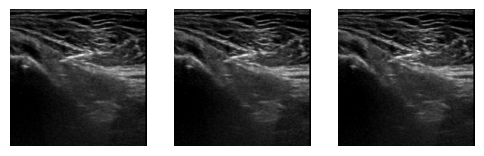

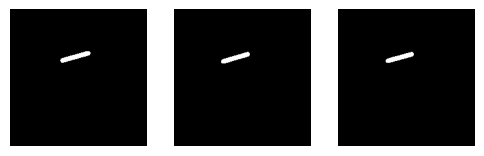

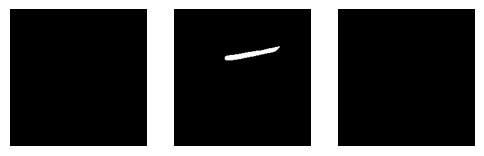

----------------------------------------------------------------


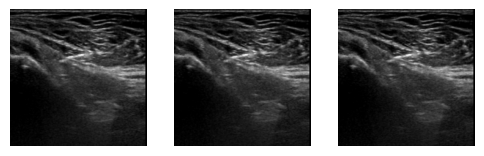

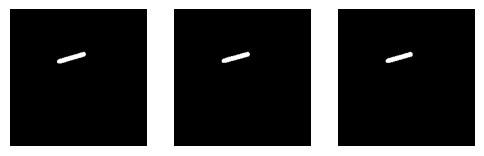

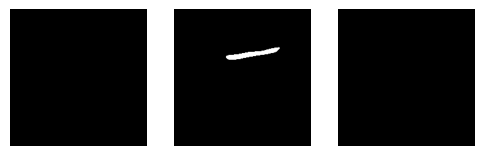

----------------------------------------------------------------


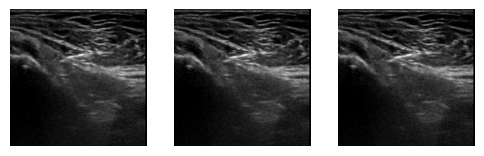

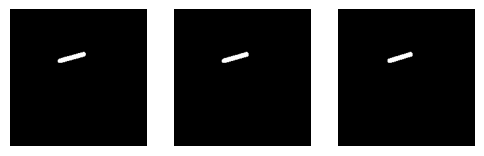

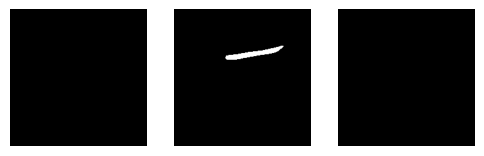

----------------------------------------------------------------


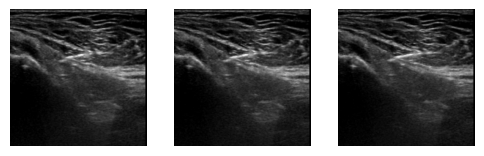

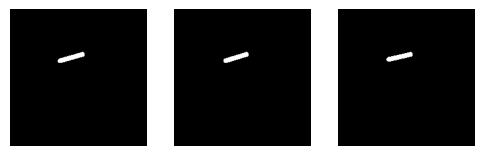

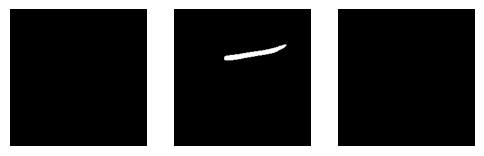

----------------------------------------------------------------
Batch: 2 Prediction Results:


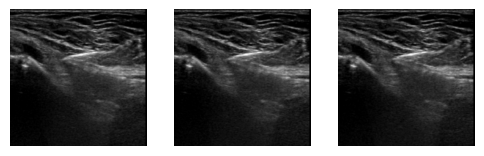

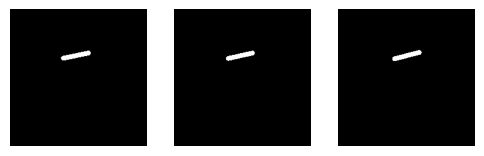

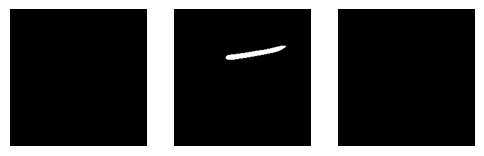

----------------------------------------------------------------


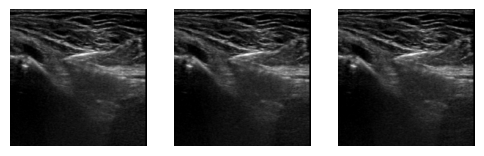

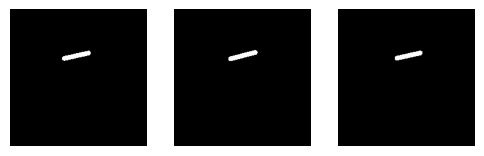

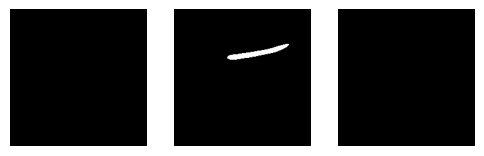

----------------------------------------------------------------


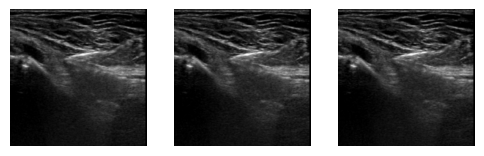

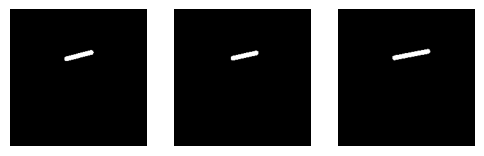

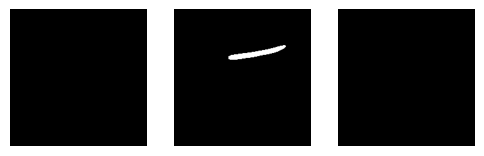

----------------------------------------------------------------


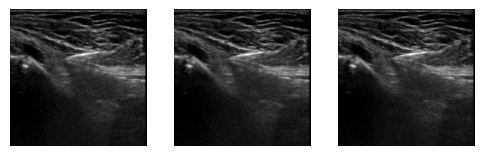

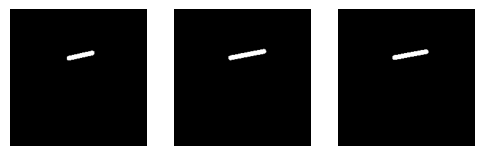

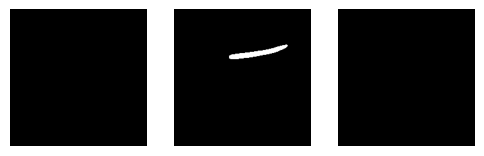

----------------------------------------------------------------
Batch: 3 Prediction Results:


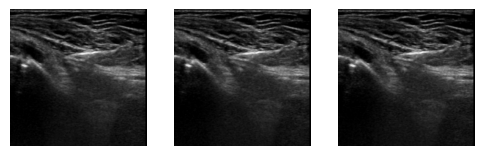

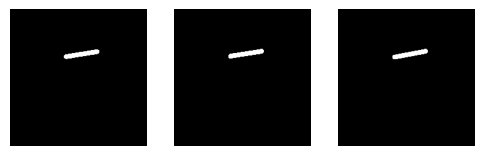

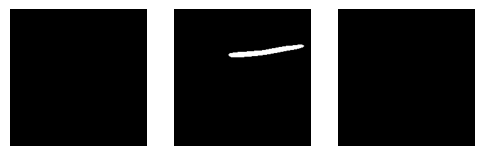

----------------------------------------------------------------


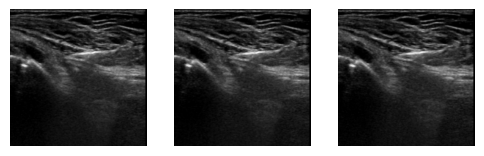

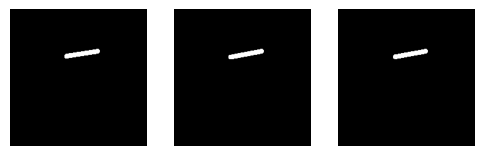

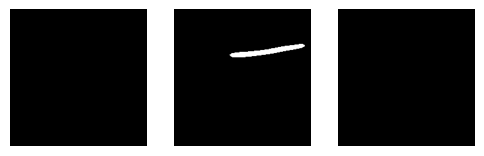

----------------------------------------------------------------


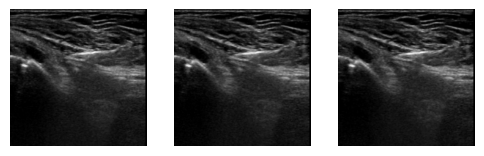

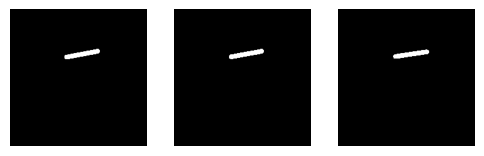

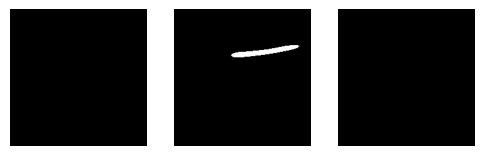

----------------------------------------------------------------


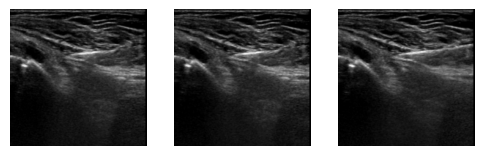

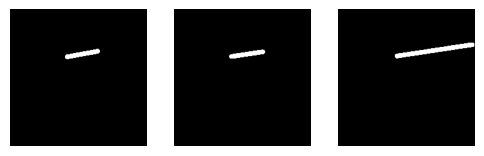

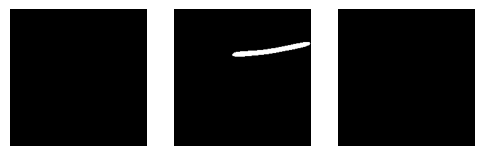

----------------------------------------------------------------
Batch: 4 Prediction Results:


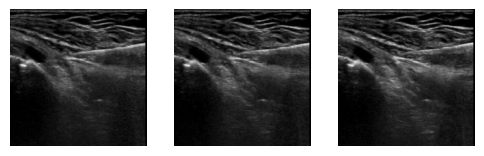

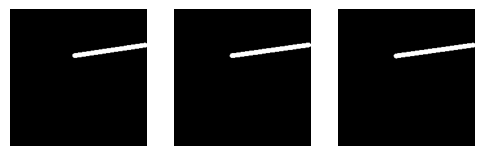

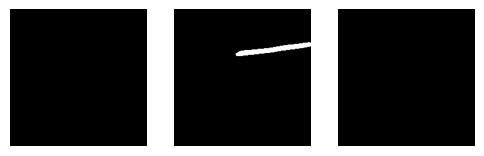

----------------------------------------------------------------


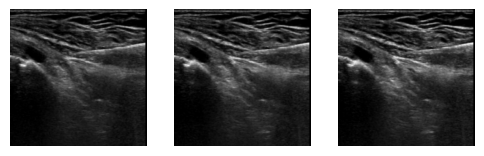

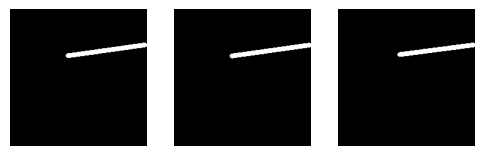

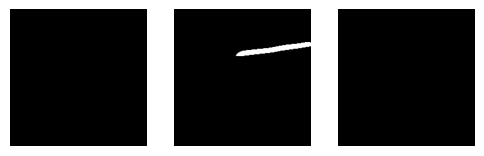

----------------------------------------------------------------


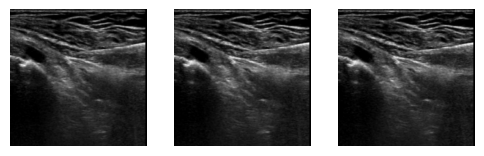

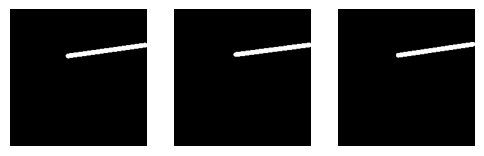

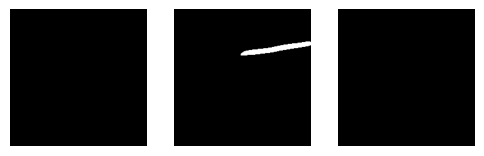

----------------------------------------------------------------


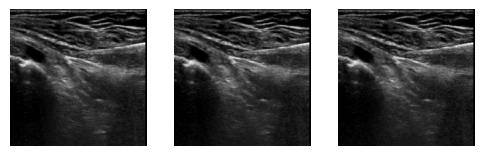

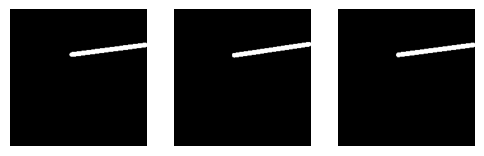

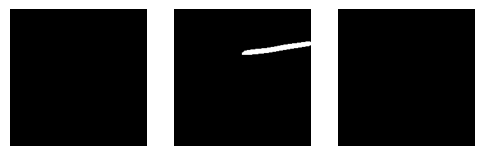

----------------------------------------------------------------
Batch: 5 Prediction Results:


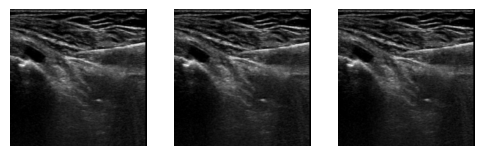

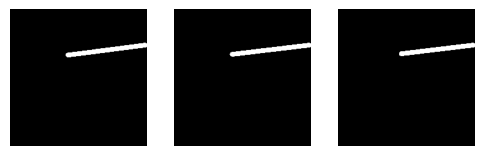

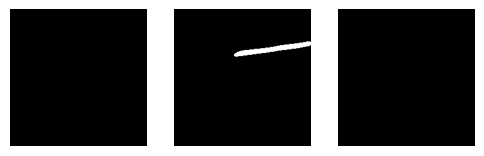

----------------------------------------------------------------


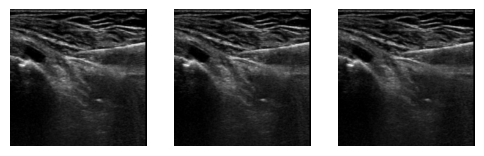

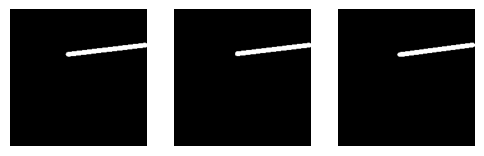

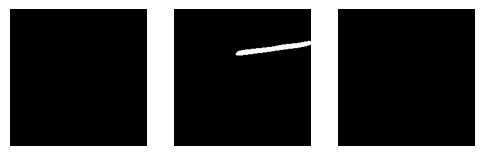

----------------------------------------------------------------


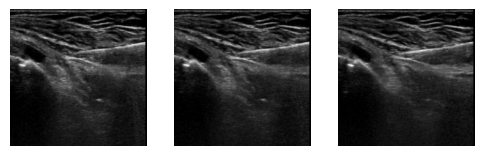

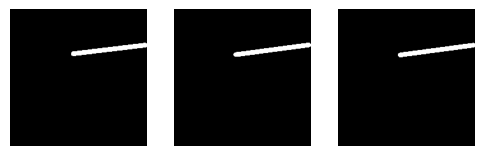

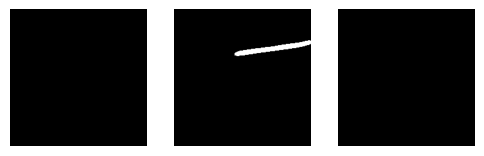

----------------------------------------------------------------


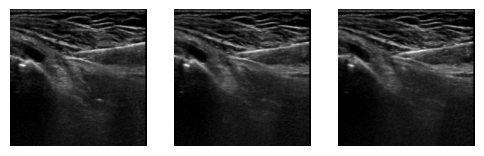

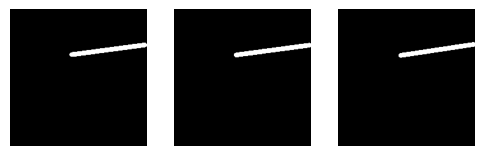

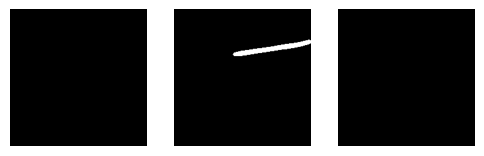

----------------------------------------------------------------
Batch: 6 Prediction Results:


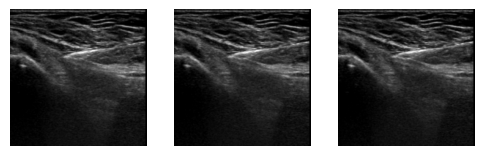

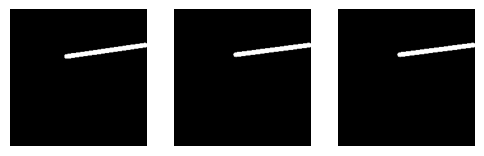

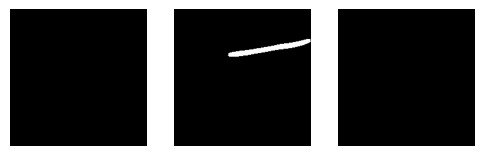

----------------------------------------------------------------


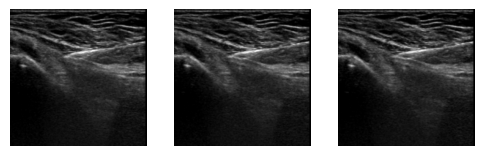

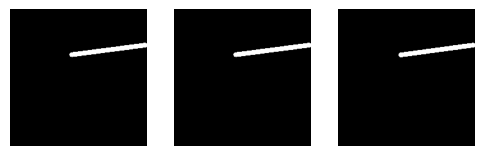

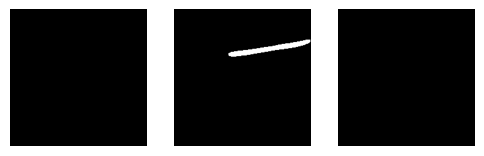

----------------------------------------------------------------


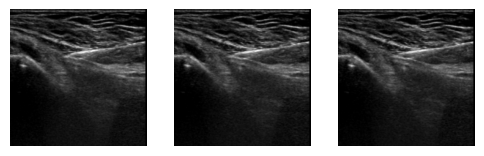

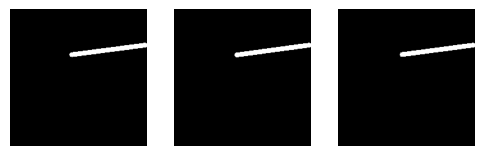

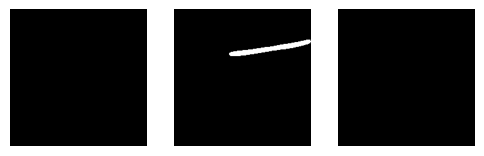

----------------------------------------------------------------


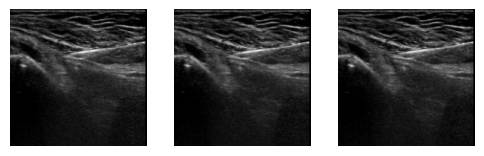

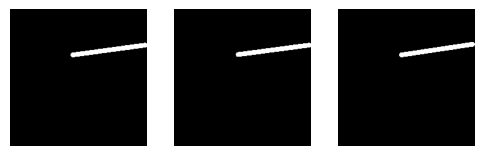

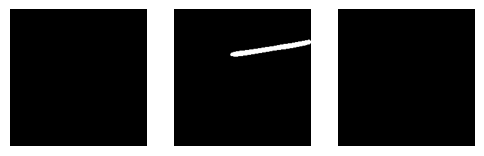

----------------------------------------------------------------
Batch: 7 Prediction Results:


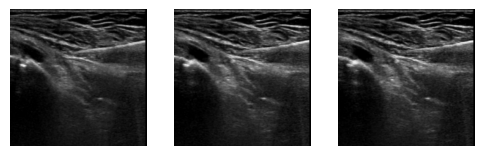

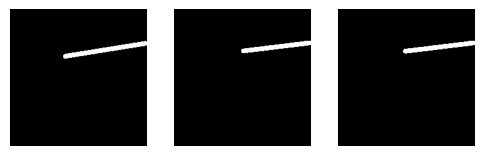

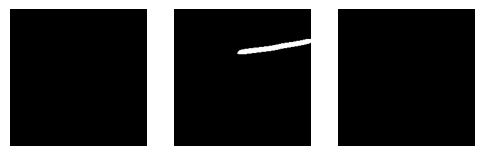

----------------------------------------------------------------


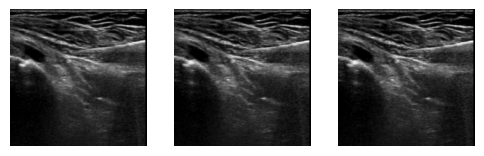

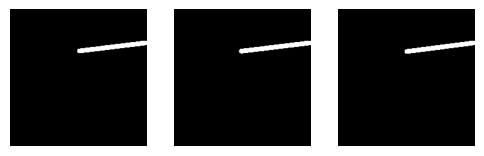

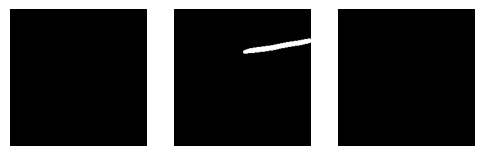

----------------------------------------------------------------


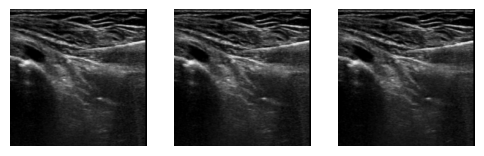

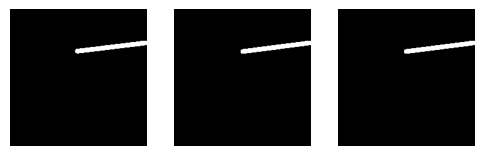

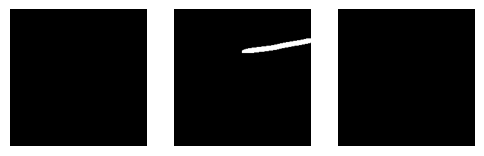

----------------------------------------------------------------


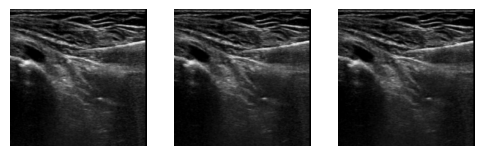

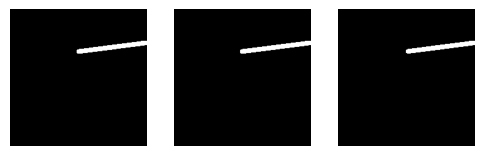

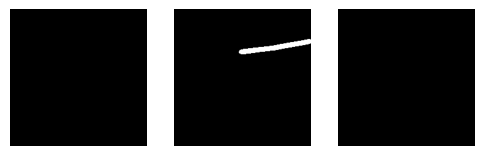

----------------------------------------------------------------
Batch: 8 Prediction Results:


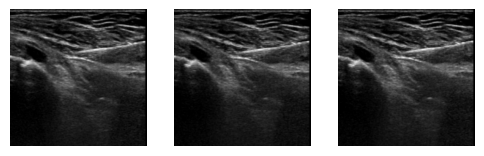

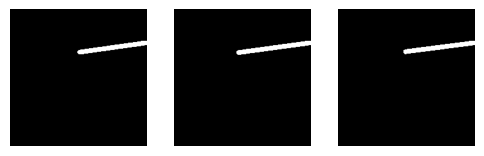

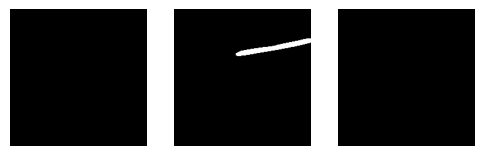

----------------------------------------------------------------


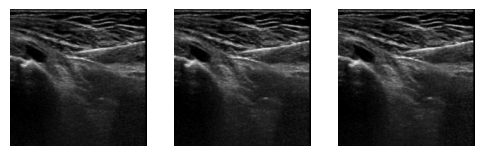

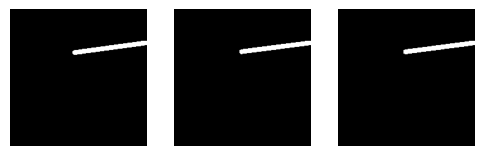

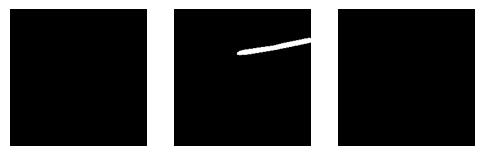

----------------------------------------------------------------


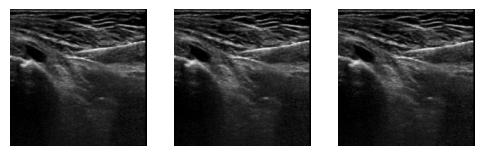

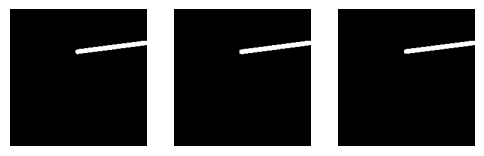

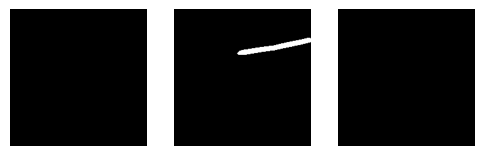

----------------------------------------------------------------


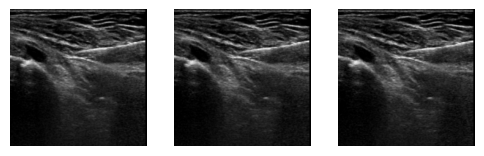

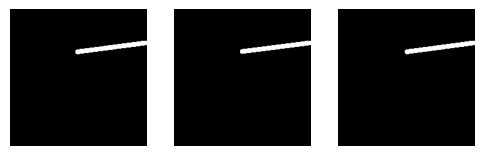

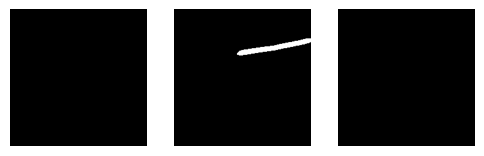

----------------------------------------------------------------


In [13]:
""" -------------------------------------------------------------------------------------------------- """
""" Experiment ID """

experiment_id = 2


""" Target Mask Time Frame"""

if experiment_id == 1:
    target_t = "all"
    out_chans = T
elif experiment_id == 2:
    target_t = "mid"
    out_chans = 1

""" -------------------------------------------------------------------------------------------------- """


# Define the model parameters
patch_size = 16
embed_dim = 768
depth = 12
num_heads = 12
mlp_ratio = 4
skip_chans = [64, 128, 256]


# Create the model
video_unetr = UNTER(
    img_size=IMAGE_SIZE,
    patch_size=patch_size,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_ratio=mlp_ratio,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
    skip_chans=skip_chans,
    out_chans=out_chans
)


# Load the best model
video_unetr.load_state_dict(torch.load(f"./video_unetr_checkpoints/video_unetr_best_{experiment_id}.pth"))
video_unetr.to(device)

visualization(video_unetr, vis_valid_loader, num_batch=16, target_t=target_t, figsize=(6, 2))